In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import os
import torch
import time
%matplotlib inline

In [2]:
class OptExperimentParser(object):
    """
    This takes in one experiment folder and parses the args.txt and the 
    values of all the runs in that folder.
    NaNs are kept so they can plotted as desired.
    """
    def __init__(self, exp_folder):
        self.exp_folder = exp_folder
        self.parse_args()
        if 'n_lrs' not in self.args: self.args['n_lrs'] = self.args['n_learning_rates']
        self.parse_runs()
        self.parse_full_schedules()
    
    def parse_args(self):
        args_path = os.path.join(self.exp_folder, 'args.txt')
        df = pd.read_csv(args_path, sep='\t', header=None, usecols=[0,1], names=['keys', 'values'])
        self.args = {k.strip():v.strip() for k,v in zip(df['keys'], df['values'])}
    
    def parse_runs(self, max_n_runs=1000, drop_last=True):       
        self.runs = {}
        for i in range(max_n_runs):
            file_path = os.path.join(self.exp_folder, 'run{}'.format(i), 'log.csv')
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                if not drop_last or int(df['global_step'].iat[-1]) == int(self.args['n_epochs_per_run']) -1:
                    self.runs['run{}'.format(i)] = df
    
    def parse_full_schedules(self):
        """       
        all_lr_schedules saved with shape (args.n_runs+1, args.n_lrs)
        here we reshape it to (args.n_runs+1, args.n_epochs)
        
        """
        checkpoint_path = os.path.join(self.exp_folder, 'checkpoint.pth.tar')
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        
        self.all_lr_schedules = checkpoint['all_lr_schedules']
        tile_factor = int(int(self.args['n_epochs_per_run']) / int(self.args['n_lrs']))
        self.all_lr_schedules = self.all_lr_schedules.view(-1, 1).repeat(1, tile_factor).view(self.all_lr_schedules.shape[0], -1)
        
        self.all_mom_schedules = checkpoint['all_mom_schedules']
        tile_factor = int(int(self.args['n_epochs_per_run']) / int(self.args['n_moms']))
        self.all_mom_schedules = self.all_mom_schedules.view(-1, 1).repeat(1, tile_factor).view(self.all_mom_schedules.shape[0], -1)
        
        self.all_wd_schedules = checkpoint['all_wd_schedules']
        tile_factor = int(int(self.args['n_epochs_per_run']) / int(self.args['n_wds']))
        self.all_wd_schedules = self.all_wd_schedules.view(-1, 1).repeat(1, tile_factor).view(self.all_wd_schedules.shape[0], -1)
    

def plot_lr_mom_wd_test(experiment_folder):
    
    exp = OptExperimentParser(experiment_folder)
    
    ## Plot
    fig = plt.figure(figsize=(20,7))
    grid_params = {'axis':'y', 'linestyle': '--', 'linewidth': 1, 'alpha':0.5}
    ax1, ax2, ax3, ax4 = [fig.add_subplot(1, 4, i) for i in range(1,5)]
    for ax in fig.axes: ax.grid(**grid_params)
  
    n_epochs = int(exp.args['n_epochs_per_run'])
    n_runs = len(exp.runs.keys()) #total # of runs so far

    first_test_acc, last_test_acc = 0, 0


    for run_idx, (run_key, run_data) in enumerate(exp.runs.items()):
        color = plt.cm.rainbow((run_idx+1)/n_runs)
        alpha = 1#(run_idx+1)/n_runs if run_idx>0 else 0.8
        linewidth = 2 if (run_idx+1)==n_runs or run_idx==0 else 1
        ax1.plot(run_data['global_step'], run_data['TRAIN/inner_lr'], color=color, alpha=alpha, linewidth=linewidth)
        ax2.plot(run_data['global_step'], run_data['TRAIN/inner_mom'], color=color, alpha=alpha, linewidth=linewidth)
        ax3.plot(run_data['global_step'], run_data['TRAIN/inner_wd'], color=color, alpha=alpha, linewidth=linewidth)
        ax4.plot(run_data['global_step'], run_data['TEST/acc'], color=color, alpha=alpha, linewidth=linewidth)
        if run_idx == 0: first_test_acc = float(run_data['TEST/acc'].iat[-1])
        if int(run_data['global_step'].iat[-1]) == n_epochs-1: last_test_acc = float(run_data['TEST/acc'].iat[-1])
        

    #print(run_data['TRAIN/inner_lr'])
    ax4.text(0.5, 0.2, 'end: {:02.2f}\% ({})'.format(last_test_acc, run_key), fontsize=25, transform=ax4.transAxes)
    ax4.text(0.5, 0.1, 'start: {:02.2f}\%'.format(first_test_acc), fontsize=25, transform=ax4.transAxes)
        

In [7]:
def plot_hyperparameters(exp_path):
    """
    Plots one more schedule than test accs since didn't evaluate last schedule.
    TODO: outer steps legend correct range when run_log_freq != 0.
    """
    
    label_size = 20
    tick_size = 15
    
    ## Create Figure
    fig = plt.figure(figsize=(21,14))#
    grid_params = {'axis':'y', 'linestyle': '--', 'linewidth': 1, 'alpha':0.5}
    ax1, ax2, ax3, ax4 = [fig.add_subplot(2, 2, i) for i in range(1,5)]
    for ax in fig.axes: 
        ax.grid(**grid_params)
        ax.tick_params(axis='both', which='major', labelsize=tick_size)
        ax.set_xlabel('epochs', size=label_size)
    ax3.ticklabel_format(axis='y', style='scientific', scilimits=(-4,-4))
    ax3.yaxis.get_offset_text().set_fontsize(tick_size)
    ax1.set_ylabel(r'$\alpha$', size=label_size)
    ax2.set_ylabel(r'$\beta$', size=label_size)
    ax3.set_ylabel(r'$\mu$', size=label_size)
    ax4.set_ylabel('test acc (\%)', size=label_size)
    
    ## Load Meta experiment
    exp = OptExperimentParser(exp_path)
    #n_epochs = int(exp.args['n_epochs_per_run'])
    n_total_schedules = exp.all_lr_schedules.shape[0]
    
    ## Make manual colorbar
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.15)
    ax_cb.tick_params(axis='both', which='major', labelsize=tick_size)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=n_total_schedules)
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=matplotlib.cm.rainbow, norm=norm, orientation='vertical')
    cb1.set_label('outer steps', size=label_size)
    plt.gcf().add_axes(ax_cb)

    
    ## Plot schedules and test acc
    for schedule_idx in range(n_total_schedules):
        color = plt.cm.rainbow((schedule_idx+1)/n_total_schedules)
        alpha = 1 if schedule_idx==n_total_schedules-1 else 0.7
        linewidth = 2 
        ax1.plot(exp.all_lr_schedules[schedule_idx], color=color, alpha=alpha, linewidth=linewidth)
        ax2.plot(exp.all_mom_schedules[schedule_idx], color=color, alpha=alpha, linewidth=linewidth)
        ax3.plot(exp.all_wd_schedules[schedule_idx], color=color, alpha=alpha, linewidth=linewidth)
        
        if schedule_idx != n_total_schedules-1:
            ax4.plot(exp.runs['run'+str(schedule_idx)]['global_step'], exp.runs['run'+str(schedule_idx)]['TEST/acc'], color=color, alpha=alpha, linewidth=linewidth)
        
    
    plt.subplots_adjust(wspace=0.2, hspace=0.25)
    #ig.savefig("./cifar10.pdf", bbox_inches='tight');

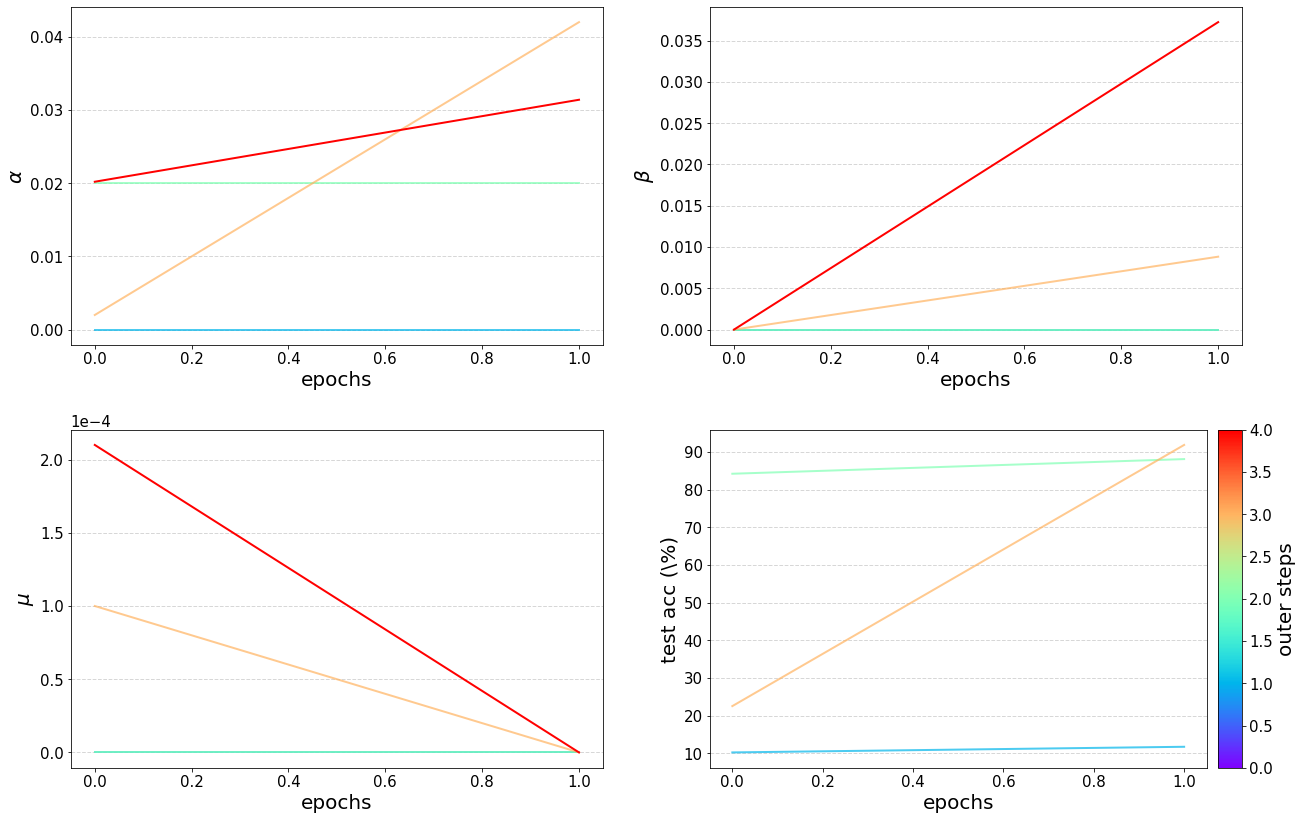

In [8]:
exp_path = '/home/paul/git/NonGreedyGradientHPO/logs/FSL_MNIST_LeNet_nr3_nepr2_learn2lrs-p0.1-t0.02_learn2moms-p0.1-t0.05_learn2wds-p0.1-t0.0001_initxavier-1_tbs512_ilr0_imom0_iwd0_olr0.1_omom0.1_HZclamp100_gradsclamp3_S0'
plot_hyperparameters(exp_path)